## P- Median Location Problem - Optimization

### Import Packages

In [17]:
#pip install pyomo
from pyomo.environ import *
import pyomo.environ as pyo
import random
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np

### Inputs

In [18]:
#Generate Data Inputs

# Select random seed
random.seed(1)

# Number of candidate locations
#n=100
n=500

#Number of locations to open
openfac=30

#Coordinate Range
rangelct=100000

#Generate random locations
coordlct_x = random.choices(range(0, rangelct), k=n)
coordlct_y = random.choices(range(0, rangelct), k=n)

#Compute distance between locations
distancelct=np.empty([n, n])
for i_index in range(n):
    for j_index in range(n):
        distancelct[i_index,j_index]=(math.sqrt(((coordlct_x[i_index]-coordlct_x[j_index])**2) +((coordlct_y[i_index]-coordlct_y[j_index])**2)))    

df = pd.DataFrame(distancelct)
df.index += 1
df.columns += 1
cij_model=df.stack().to_dict()

#Generate demand between locations
demandlct = random.choices(range(1, 50), k=n)
demanddf = pd.DataFrame(demandlct)
demanddf.index += 1
dj_model=demanddf.to_dict()
dj_model=dj_model[0]

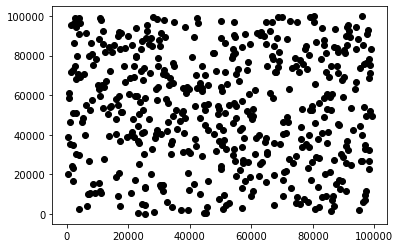

In [19]:
plt.plot(coordlct_x, coordlct_y, 'o', color='black');

### Sets

In [20]:
# Create Model
model = AbstractModel()

# Set of candidate locations
model.M = RangeSet(n)
# Set of customer nodes
model.N = RangeSet(n)

### Parameters

In [21]:
# Number of facilities
model.p = openfac
# d[j] - demand of customer j
model.d = Param(model.N, initialize=dj_model)
# c[i,j] - unit cost of satisfying customer j from facility i
model.c = Param(model.M, model.N, initialize=cij_model)

### Decision Variables

In [22]:
# x[i,j] - 1 if customer j is supplied by location i
model.x = Var(model.M, model.N, within=Binary)

# y[i] - a binary value that is 1 if a facility is located at location i
model.y = Var(model.M, within=Binary)

### Objective Function

In [23]:
# Minimize the demand-weighted total cost
def cost_(model):
    return sum(model.d[j]*model.c[i,j]*model.x[i,j] for i in model.M for j in model.N)
model.cost = Objective(rule=cost_)

### Constraints

In [24]:
# All of the demand for customer j must be satisfied
def demand_(model, j):
    return sum(model.x[i,j] for i in model.M) == 1.0
model.demand = Constraint(model.N, rule=demand_)

In [25]:
# Exactly p facilities are located
def facilities_(model):
    return sum(model.y[i] for i in model.M) == model.p
model.facilities = Constraint(rule=facilities_)

In [26]:
# Demand nodes can only be assigned to open facilities 
def openfac_(model, i, j):
    return model.x[i,j] <= model.y[i]
model.openfac = Constraint(model.M, model.N, rule=openfac_)

### Solve Model

In [27]:
instance = model.create_instance()
opt = pyo.SolverFactory('gurobi')
opt.solve(instance, options={'TimeLimit': 10000},tee=True)

Set parameter Username
Academic license - for non-commercial use only - expires 2022-11-27
Read LP format model from file C:\Users\NUNORI~1\AppData\Local\Temp\tmpua1k816t.pyomo.lp
Reading time = 0.93 seconds
x250501: 250502 rows, 250501 columns, 750501 nonzeros
Set parameter TimeLimit to value 10000
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 250502 rows, 250501 columns and 750501 nonzeros
Model fingerprint: 0xbfed0d0b
Variable types: 1 continuous, 250500 integer (250500 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e+02, 6e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+01]
Presolve removed 1 rows and 1 columns
Presolve time: 1.65s
Presolved: 250501 rows, 250500 columns, 750500 nonzeros
Variable types: 0 continuous, 250500 integer (250500 binary)
Found heuristic solution: objective 1.172506e+08

Deterministic concurr

{'Problem': [{'Name': 'x250501', 'Lower bound': 74794047.84931499, 'Upper bound': 74794047.84931502, 'Number of objectives': 1, 'Number of constraints': 250502, 'Number of variables': 250501, 'Number of binary variables': 250500, 'Number of integer variables': 250500, 'Number of continuous variables': 1, 'Number of nonzeros': 750501, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '8.18614387512207', 'Error rc': 0, 'Time': 10.402815818786621}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

### Read output variables

In [28]:
xij_dic = {i:int(np.round(pyo.value(j))) for (i,j) in instance.x.items()}
xij = pd.DataFrame(xij_dic.values(), index = xij_dic.keys()).unstack()
linkindex = np.where(xij == 1)

### Plot results

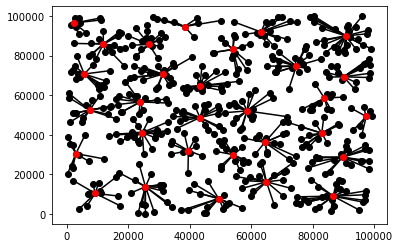

In [29]:
def connectpoints(x,y,p1,p2):
    x1, x2 = x[p1], x[p2]
    y1, y2 = y[p1], y[p2]
    plt.plot([x1,x2],[y1,y2],'k-')

for i_index in range(len(linkindex[0])): 
    connectpoints(coordlct_x,coordlct_y,linkindex[0][i_index],linkindex[1][i_index])
    
plt.plot(coordlct_x, coordlct_y, 'o', color='black');

yi_dic = {i:int(value(j)) for (i,j) in instance.y.items()}
yi = pd.DataFrame(yi_dic.values(), index = yi_dic.keys()).unstack()
facilityindex = np.where(yi == 1)

for i_index in range(len(facilityindex[0])): 
    plt.plot(coordlct_x[facilityindex[0][i_index]], coordlct_y[facilityindex[0][i_index]], 'o', color='red');
 